In [1]:
!pip install openai huggingface_hub tiktoken faiss-cpu langchain unstructured --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 92.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 89.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.1/275.1 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 44.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.3 MB/s eta

In [2]:
from langchain.llms import OpenAI, HuggingFaceHub
from langchain.prompts import PromptTemplate, SystemMessagePromptTemplate, ChatPromptTemplate, ChatMessagePromptTemplate, HumanMessagePromptTemplate
from langchain.schema import SystemMessage, HumanMessage, AIMessage
from langchain.chat_models import ChatOpenAI, ChatCohere
from langchain.agents import initialize_agent, load_tools, AgentType, Tool
from langchain.utilities import GoogleSerperAPIWrapper
from langchain.document_loaders import DirectoryLoader, PDFMinerLoader
from langchain.chains import LLMChain

import os

os.environ["SERPER_API_KEY"] = ""
os.environ["HUGGINGFACEHUB_API_TOKEN"] = ""
os.environ["OPENAI_API_KEY"] = ""


Methodology:

1. Collect the cultural context and store the information as python strings.
    - The cultural profile is constructed by a LangChain SelfAskWithSearch Agent which follows a self-ask prompting method and has google serper API as a tool to browse google search.

2. Build prompt templates taking these pieces of information into account.
    - Completion and Chat Langchain prompt templates are instantiated by combining the cultural profile as a system prompt (indicates the persona), the experiment instructions (decision environment), and the subject's task (choice set)

3. Instantiate model (openai, cohere, huggingfacehub,...)
    - We experiment with a varietey of open- and close-source models of completion as well as chat type.

4. Build LLM chain
    - Prompt templates and models are combines into a LangChain LLMChain

5. Experiment set up
    - We experimented by varying the model and temperatures. We test a total of 10 temperatures for each model and compare results across completion and chat models.

## Fetch/Search Cultural Context

- [langchain self-ask-with-search](https://python.langchain.com/docs/modules/agents/agent_types/self_ask_with_search.html)

- The self-ask prompting method [paper](https://ofir.io/self-ask.pdf)

In [3]:
# relevant functions to build a LangChain Agent with search capabilities and additional data to build subject's profile.
# We fix the model type to be completion (davinci, cohere, or huggingface) to tighten the confidence intervals (chat features are noisy) and reduce cost.
# The agent powered by this completion LLM is capable of utilizing google search (via Google Serper API) as a tool to generate intermediate answers.
# We leverage these intermediate answers dynamically by prompting the model to continue searching the web until the best (expected or approximated) answer (what it thinks you want or expect to se) is generated or we reach a limit.
# It does so by generating intermediate answers, and then generating internal questions to guide behavior.
# Answer -> Follow-up Questions -> Intermediate answer -> ... -> final answer. The number of iterations (number of interm. ans.) depends on the complexity of the question and the follow-up questions generated.
def run_search_agent(model: str,
                     prompt_search: str):
    '''
    Function to initialize and run a LangChain SELF_ASK_WITH_SEARCH Agent with access to google serper.
    params:
        prompt (str): Instructions for the agent about what to search.
    '''
    # Initialize the LLM
    if model == 'openai':
        llm = OpenAI(model_name='text-davinci-003',
                          max_tokens=500, temperature=0.5)

    elif model == 'hf':
        llm = HuggingFaceHub(repo_id = 'google/flan-t5-large',
                                  model_kwargs = {"temperature": 0.5, "max_length": 500})
    else:
        raise ValueError("Invalid model. Please choose 'openai'.")

    search = GoogleSerperAPIWrapper()
    tools = [
        Tool(
            name="Intermediate Answer",
            func=search.run,
            description="useful for when you need to ask with search",
        )
    ]

    self_ask_with_search = initialize_agent(tools, llm,
                                            agent=AgentType.SELF_ASK_WITH_SEARCH,
                                            verbose=True,
                                            max_iterations=10,
                                            early_stopping_method="generate",
                                            handle_parsing_errors=True)

    result = self_ask_with_search.run(prompt_search)

    return result


### Prompt parameters

Think if there is anything else we want to parameterize (i.e., make a variable) for the prompt.

1. *tribe_to_search* -> The name of the tribe or culture we want to search for.
2. *relevant_factors* -> Keywords or short phrases describing the type of information we want to search for about the given tribe. I think of this as socio-cultural-economic dimensions we want our agent to consider when searching the web. Also, I think it should mimic our model of behavior. Stick with me for a little bit. Do we believe lifestyle and average age are relevant factors for describing any behavior? The purpose of the model is to use the information in the prompt to. **One improvement could be to explicitly define the questions the Agent should search for instead of keywords.

1) describe in detail the socio-economic traits of a given tribe or culture,

2) use that detailed description to construct a behavioral profile of an artificial member of that tribe (a more general term could be social group if we think this might help model any small scale society), and

3) adopt that behavioral profile as its persona (in the form of a system prompt) while simulating participation in an economic experiment (in the form of a human message or task prompt) to generate behavioral responses (in the form of model outputs, basically the action selected from the action space of the experiment).

3. *profile_length* -> The number of words the description of the culture should have. This is probably a somewhat irrelevant parameter because it is unlikely the model will actually generate the number of words we ask for.

4. Any other ides? Maybe we could add a list of keywords that describe more accurately how the profile should be constructed and in what format. Good excuse to brainstorm over some beers.

In [4]:

# prompt inputs for search
tribe_to_search = "The Hazda"
relevant_factors = ["lifestyle," "average age", "culture", "economic system", "political ideologies present", "values"]
profile_length = 550

# Generate persona based on profifle and system prompt
prompt_search = f"Please construct a detailed and comprehensive {profile_length}-word cultural profile on the {tribe_to_search}. " \
        + f" The profile must cover the following socio-economic relevant factors {relevant_factors} ."

# openai's davinci works better as an agent than T5-large
tribe_prof = run_search_agent(model='openai',
                              prompt_search=prompt_search)

tribe_prof



> Entering new AgentExecutor chain...
 Yes.
Follow up: What is the lifestyle of the Hazda?
Intermediate answer: Known for shunning material possessions and social hierarchy, the Hadza roam as needed to find game, tubers and wild berries. Hunter-gatherer societies understand that their survival depends on natural resources.

Follow up: What is the average age of the Hazda?
Intermediate answer: Like other indigenous tribes, the average Hadza life expectancy at birth is low (32.5 years) [60,61] compared with Poland (78.2 years) [62].

Follow up: What are the cultural practices of the Hazda?
Intermediate answer: Traditional Hadza, like Onwas and his camp mates, live almost entirely free of possessions. The things they own—a cooking pot, a water container, an ax—can be wrapped in a blanket and carried over a shoulder. Hadza women gather berries and baobab fruit and dig edible tubers. Men collect honey and hunt.

Follow up: What is the economic system of the Hazda?
Intermediate answer: Kno

'The Hazda value equality highly, recognizing no official leaders. Hadza women have a great amount of autonomy and participate equally in decision-making. They honor their ancestors through rituals and ceremonies, and they have a communal and egalitarian social structure with strong obligations to share resources, particularly food. They rely on natural resources for their survival and have a preoccupation with equality, subverting differences of power, wealth and status. They have a diet consisting of about 70% plant foods, including tubers, and honey represents a substantial portion of their diet. They have a culture of shunning material possessions and have developed land use plans to designate areas for farming, grazing, and full protection.'

In [ ]:
# what else besides this context should we add to the prompt?

In [ ]:
ache_tribe_profile = """
The Ache tribe of Paraguay is a small indigenous group living in the forests of eastern Paraguay. The Aché have a traditional lifestyle based on hunting, fishing, and gathering wild fruits and other plants. They hunt with bows and arrows, spears, traps, and pits, and fish in rivers with bows and arrows, dams, and nets. The average age of the Ache is not known, but estimates suggest that the majority of the population is under 40 years old.

The Ache tribe has a rich cultural heritage, with a strong emphasis on oral tradition and storytelling. The tribe also has a strong spiritual belief system, with many traditional ceremonies and rituals. In terms of economic system, the Ache are largely self-sufficient, relying on hunting, gathering, and fishing for their sustenance. They also engage in some limited trade with nearby villages.

In terms of political ideologies, the Ache are largely independent and self-governing. They have a strong sense of communal ownership and responsibility, and rely on consensus-based decision making. They also have a strong sense of justice and fairness, with a strong emphasis on respect and cooperation.

The Ache value family and community above all else. They have a strong sense of loyalty and commitment to their tribe and to their environment. They also have a strong respect for nature and the environment, and are committed to preserving their traditional way of life"""

## Design Prompts

In [ ]:
# This is the template for the system prompt that is supposed to describe the persona the LLM is expected to adopt.
# Note that subject_profile is an input variable for LangChain's PromptTemplate. This is why there is no f-string formatting although we use the same syntax (LangChain does the f-formatting in the background).
system_prompt_template = "You are a member of a tribe with the following characteristics: {subject_profile}"

# Create the system message template
system_message_prompt = SystemMessagePromptTemplate.from_template(system_prompt_template)

# Build the chat prompt template
chat_system_prompt = ChatPromptTemplate.from_messages([system_message_prompt])

print(f"Chat prompt: {chat_system_prompt} \n")

# Build the completion prompt template
completion_system_prompt = PromptTemplate.from_template(template=system_prompt_template)

print(f"\nCompletion prompt: {completion_system_prompt}")

Chat prompt: input_variables=['subject_profile'] messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['subject_profile'], template='You are a member of a tribe with the following characteristics: {subject_profile}'))] 


Completion prompt: input_variables=['subject_profile'] template='You are a member of a tribe with the following characteristics: {subject_profile}'


## Instantiate models

In [ ]:
# CLOSED-SOURCE MODELS (OpenAI or Cohere models)
gpt_4 = ChatOpenAI(model='gpt-4', temperature=0, max_tokens=20)
chatgpt = ChatOpenAI(model='gpt-3.5-turbo', temperature=0, max_tokens=20)
davinci3 = OpenAI(model="text-davinci-003", temperature=0, max_tokens=50)

In [ ]:
# test each closed-source model with a trivial prompt and cultural context


In [ ]:
# OPEN-SOURCE MODELS (huggingface text-generation or text2text-generation models). Pick from the following repositories
## https://huggingface.co/models?pipeline_tag=text2text-generation&sort=trending
## https://huggingface.co/models?pipeline_tag=text-generation&sort=trending

t5_base = HuggingFaceHub(repo_id="google/flan-t5-base")
t5_large = HuggingFaceHub(repo_id="google/flan-t5-large")
mistral = HuggingFaceHub(repo_id="mistralai/Mistral-7B-v0.1")
#llama = HuggingFaceHub

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:127: FutureWarning: '__init__' (from 'huggingface_hub.inference_api') is deprecated and will be removed from version '0.19.0'. `InferenceApi` client is deprecated in favor of the more feature-complete `InferenceClient`. Check out this guide to learn how to convert your script to use it: https://huggingface.co/docs/huggingface_hub/guides/inference#legacy-inferenceapi-client.
  warnings.warn(warning_message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:127: FutureWarning: '__init__' (from 'huggingface_hub.inference_api') is deprecated and will be removed from version '0.19.0'. `InferenceApi` client is deprecated in favor of the more feature-complete `InferenceClient`. Check out this guide to learn how to convert your script to use it: https://huggingface.co/docs/huggingface_hub/guides/inference#legacy-inferenceapi-client.
  warnings.warn(warning_message, FutureWar

In [ ]:
# test each closed-source model with a trivial prompt and cultural context


## Build Chains

In [ ]:
from langchain.chains import LLMChain

# insert your favorite completion model for the llm argument
completion_chain = LLMChain(llm=t5_base,
                            prompt=completion_system_prompt)

# insert your favorite chat model for the llm argument
chat_chain = LLMChain(llm=gpt_4,
                      prompt=chat_system_prompt)

In [ ]:
# let's test the chains
# Pay particular attention to how the responses differ, for the same prompt, between completion and chat models.
# This suggests we need different prompts to optimize the expected behavior of each type of model.
completion_chain({'subject_profile': tribe_prof})

{'subject_profile': 'The Hazda tribe is a hunter-gatherer society located in northern Tanzania. They have an average life expectancy of 31.5 years and are known for their egalitarian and autonomous culture. Their economic system is based on hunting and foraging, and they have no system of chiefs or hierarchy. They value equality, sharing, cooperation, community, kinship, and respect for nature.',
 'text': 'You are a member of the Hazda tribe'}

In [ ]:
chat_chain({'subject_profile': tribe_prof})

{'subject_profile': 'The Hazda tribe is a hunter-gatherer society located in northern Tanzania. They have an average life expectancy of 31.5 years and are known for their egalitarian and autonomous culture. Their economic system is based on hunting and foraging, and they have no system of chiefs or hierarchy. They value equality, sharing, cooperation, community, kinship, and respect for nature.',
 'text': 'As a member of the Hazda tribe, my daily life revolves around the basic tasks of survival. I wake up with the sun, and my first task is to gather firewood for the day. This is a communal task, and everyone in the'}

## Experiment set up

The experiment prompt depends on the action space and therefore will depend on the specific experiment being considered. This is because different games measure different behaviors and to do so the prompt different tasks or actions from the experiment subjects. Hence, we should try to parameterize this prompt as much as possible to allow greater flixibility of the architecture. With this in mind, the relevant parameters might be the following:

1. *experiment* -> The description/explanation of the economic experiment/game. If there is a standard description, use that, otherwise construct a description based on the literature.
2. *subject_task* -> What is the experiment subject supposed to do in the experiment or game. This should reflect the decision/action space available to the participant. ***This part can be improved by few shot prompting or describing the action space differently (like in the form of a vector in the string '[exchange, reject]'***
3. If we do decide to opt for a "minimally articulated" prompt that substitutes english sentences for objects (like vectors, lists, or dictionaries), then we should parameterize that.

In [ ]:
completion_system_prompt = f"You are a member of a tribe with the following characteristics: {tribe_prof}"
experiment = f"you are given a mug while waiting for a researcher to call your name. When you are called he offers to exchange your mug for a cookie."
subject_task = "Do you exchange the mug or reject the cookie? You must reply in one word with either 'exchange' or 'reject' and explain why you chose that. For example, 'I reject' or 'I exchange'"


In [ ]:
# test completion models
completion_prompt = f"{completion_system_prompt} \n\n Experiment description: {experiment} \n\n Task: {subject_task}"

t5_base_res = t5_base(completion_prompt)
t5_large_res = t5_large(completion_prompt)
davinci3_res = davinci3(completion_prompt)
mistral_res = mistral(completion_prompt)

print(f"T5 base: {t5_base_res} \nT5 large: {t5_large_res} \nDavinci (GPT) 3: {davinci3_res} \nMistral: {mistral_res}")

T5 base: reject 
T5 large: I reject 
Davinci (GPT) 3:  and explain why.

I reject. I believe that the Hazda tribe values sharing resources and autonomy, and exchanging my mug for a cookie would not be in line with these values. 
Mistral:  or 'I exchange because I like cookies'. 












In [ ]:
# test chat models
from langchain.schema import SystemMessage, HumanMessage, AIMessage

#sys_template = "You are a member of a tribe with the following characteristics: {subject_profile}"
system_prompt = f"You are a member of a tribe with the following characteristics: {tribe_prof}"
messages = [
    SystemMessage(content=system_prompt),
    HumanMessage(content=completion_prompt)
]
gpt_4_res = gpt_4(messages)
chatgpt_res = chatgpt(messages)

print(f"GPT-4: {gpt_4_res} \nChatGPT {chatgpt_res}")

GPT-4: content='I exchange. The Hazda tribe values sharing resources and the mug can be seen as a resource.' 
ChatGPT content='I reject.\n\nExplanation: As a member of the Hazda tribe, our values include sharing resources and'


# Experiments/Results

We experiment with various models by varying the temperature parameter and economic experiment (endowment effect or ultimatum game)  

In [ ]:
import time as time
import pandas as pd

temperatures = [0.1, 0.3, 0.5, 0.7, 0.9, 1, 1.2, 1.4, 1.6, 1.8]
temperatures

[0.1, 0.3, 0.5, 0.7, 0.9, 1, 1.2, 1.4, 1.6, 1.8]

In [ ]:
# Util for counting exchange/reject
import re

def count_endowment_responses(responses):
    exchange_count = 0
    reject_count = 0

    for response in responses:
        string_lower = response.lower()  # Convert the string to lowercase to handle case variations
        if 'reject' in string_lower:
            reject_count += 1
        elif 'exchange' in string_lower:
            exchange_count += 1

    return exchange_count, reject_count

# Example usage:
strings = ["Exchange completed successfully", "Subject rejected the proposal", "Rejected for further testing", "exchange initiated"]
exchanges, rejects = count_endowment_responses(strings)
print(f"Exchanges: {exchanges}, Rejects: {rejects}")

Exchanges: 2, Rejects: 2


In [ ]:
# additional tribes' profiles
ache_profile_chatGPT = """
"""

## Endowment Effect

Add description of endowment effect game and brief literature review.

In [ ]:
system_prompt = f"You are a member of a tribe with the following characteristics: {ache_tribe_profile}"
experiment = f"you are given a mug while waiting for a researcher to call your name. When you are called he offers to exchange your mug for a cookie."
subject_task = "Do you exchange the mug or reject the cookie? You must reply in one word with either 'exchange' or 'reject' and explain why you chose that. For example, 'I reject' or 'I exchange'"

# completion prompt
completion_prompt = f"{system_prompt} \n\n Experiment description: {experiment} \n\n Task: {subject_task}"

# chat prompt (i.e., langchain messages)
messages = [
    SystemMessage(content=system_prompt),
    HumanMessage(content=completion_prompt)
]

## Open source completion vs Closed source completion (T5_base vs T5-large vs Davinci)


In [ ]:
# T5 base experiment
t5_base_results = {"Responses": [],
                "Response time": [],
                "Temperature": []}

for temp in temperatures:
    start_time = time.time()

    t5_base = HuggingFaceHub(repo_id="google/flan-t5-base",
                   model_kwargs={"temperature": temp,
                                 "max_length": 20})
    response = t5_base(completion_prompt)

    t5_base_results["Responses"].append(response)
    t5_base_results["Response time"].append(time.time() - start_time)
    t5_base_results["Temperature"].append(temp)

t5_base_results_df = pd.DataFrame(t5_base_results)
print(f"Results dataframe: \n{t5_base_results_df}\n\nCounts: {count_endowment_responses(t5_base_results_df['Responses'])}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:127: FutureWarning: '__init__' (from 'huggingface_hub.inference_api') is deprecated and will be removed from version '0.19.0'. `InferenceApi` client is deprecated in favor of the more feature-complete `InferenceClient`. Check out this guide to learn how to convert your script to use it: https://huggingface.co/docs/huggingface_hub/guides/inference#legacy-inferenceapi-client.
  warnings.warn(warning_message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:127: FutureWarning: '__init__' (from 'huggingface_hub.inference_api') is deprecated and will be removed from version '0.19.0'. `InferenceApi` client is deprecated in favor of the more feature-complete `InferenceClient`. Check out this guide to learn how to convert your script to use it: https://huggingface.co/docs/huggingface_hub/guides/inference#legacy-inferenceapi-client.
  warnings.warn(warning_message, FutureWar

Results dataframe: 
  Responses  Response time  Temperature
0    reject      12.346377          0.1
1    reject      11.519072          0.3
2    reject       4.260822          0.5
3    reject       5.699025          0.7
4    reject       3.370193          0.9
5    reject       1.016146          1.0
6    reject       0.762604          1.2
7    reject       0.895310          1.4
8    reject       0.742278          1.6
9    reject       0.799843          1.8

Counts: (0, 10)


In [ ]:
# T5 large experiment
t5_results = {"Responses": [],
            "Response time": [],
            "Temperature": []}

for temp in temperatures:
    start_time = time.time()

    t5_large = HuggingFaceHub(repo_id="google/flan-t5-large",
                   model_kwargs={"temperature": temp,
                                 "max_length": 20})
    response = t5_large(completion_prompt)

    t5_results["Responses"].append(response)
    t5_results["Response time"].append(time.time() - start_time)
    t5_results["Temperature"].append(temp)

t5_large_results_df = pd.DataFrame(t5_results)
print(f"Results dataframe: \n{t5_large_results_df}\n\nCounts: {count_endowment_responses(t5_large_results_df['Responses'])}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:127: FutureWarning: '__init__' (from 'huggingface_hub.inference_api') is deprecated and will be removed from version '0.19.0'. `InferenceApi` client is deprecated in favor of the more feature-complete `InferenceClient`. Check out this guide to learn how to convert your script to use it: https://huggingface.co/docs/huggingface_hub/guides/inference#legacy-inferenceapi-client.
  warnings.warn(warning_message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:127: FutureWarning: '__init__' (from 'huggingface_hub.inference_api') is deprecated and will be removed from version '0.19.0'. `InferenceApi` client is deprecated in favor of the more feature-complete `InferenceClient`. Check out this guide to learn how to convert your script to use it: https://huggingface.co/docs/huggingface_hub/guides/inference#legacy-inferenceapi-client.
  warnings.warn(warning_message, FutureWar

Results dataframe: 
  Responses  Response time  Temperature
0  I reject       2.045087          0.1
1  I reject       2.200532          0.3
2  I reject       2.657448          0.5
3  I reject       2.195276          0.7
4  I reject       2.339284          0.9
5  I reject       2.297343          1.0
6  I reject       2.367074          1.2
7  I reject       1.832611          1.4
8  I reject       1.795879          1.6
9  I reject       2.012053          1.8

Counts: (0, 10)


In [ ]:
# Davinci experiment
davinci_results = {"Responses": [],
                "Response time": [],
                "Temperature": []}

for temp in temperatures:
    start_time = time.time()

    davinci = OpenAI(model="text-davinci-003",
                     temperature=temp, max_tokens=20)

    response = davinci(completion_prompt)

    davinci_results["Responses"].append(response)
    davinci_results["Response time"].append(time.time() - start_time)
    davinci_results["Temperature"].append(temp)

davinci_results_df = pd.DataFrame(davinci_results)
print(f"Results dataframe: \n{davinci_results_df}\n\nCounts: {count_endowment_responses(davinci_results_df['Responses'])}")

Results dataframe: 
                                           Responses  Response time  \
0   and explain why.\n\nI reject. I value the mug...       0.971078   
1   and explain why.\n\nI reject. I value the mug...       1.002598   
2   and explain why you chose that. \n\nI reject....       1.272818   
3   and then explain why.\n\nI reject. I value th...       1.561781   
4   and then explain why.\n\nI reject. I value th...       1.065465   
5   \nI exchange. I value family and community mo...       1.082496   
6   \n\nI reject. Although the promise of trying ...       1.680813   
7   Dutch allyers ruling fits as this four claizz...       1.207026   
8    \n\nI reject. While the offer of a cookie is...       1.825816   
9   because_______ \n\nI reject because I do not ...       1.389149   

   Temperature  
0          0.1  
1          0.3  
2          0.5  
3          0.7  
4          0.9  
5          1.0  
6          1.2  
7          1.4  
8          1.6  
9          1.8  

Counts: (1

## Open Source chat vs Closed Source chat

In [ ]:
# ChatGPT Experiment
chatGPT_results = {"Responses": [],
                "Response time": [],
                "Temperature": []}

model_test = ["gpt-3.5-turbo", "gpt-4"]

for temp, model_i in zip(temperatures, model_test):
    start_time = time.time()

    chatgpt = ChatOpenAI(model=model_i,
                         temperature=temp, max_tokens=20)

    response = chatgpt(messages)

    chatGPT_results["Responses"].append(response.content)
    chatGPT_results["Response time"].append(time.time() - start_time)
    chatGPT_results["Temperature"].append(temp)

chatGPT_results_df = pd.DataFrame(chatGPT_results)
print(f"Results dataframe: \n{chatGPT_results_df}\n\nCounts: {count_endowment_responses(chatGPT_results_df['Responses'])}")


Results dataframe: 
                                           Responses  Response time  \
0  I reject. The mug holds sentimental value and ...       1.464992   
1  I reject. The mug holds sentimental value to m...       0.906684   
2  I reject. The mug holds significant cultural a...       1.192232   
3  I reject. The mug holds sentimental value and ...       0.909628   
4  I reject. As a member of the Ache tribe, I val...       1.541428   
5  I reject.\n\nExplanation: The mug holds sentim...       1.037681   
6  I reject. The mug holds significant value to m...       0.956409   
7  I exchange.\n\nExplanation: I choose to exchan...       1.082139   
8  I would reject the cookie. As a member of the ...       0.957726   
9  Disclaimers: \n\n1. As an AI language model, I...       1.341895   

   Temperature  
0          0.1  
1          0.3  
2          0.5  
3          0.7  
4          0.9  
5          1.0  
6          1.2  
7          1.4  
8          1.6  
9          1.8  

Counts: (1

In [ ]:
# GPT-4 experiment
GPT4_results = {"Responses": [],
                "Response time": [],
                "Temperature": []}

for temp in temperatures:
    start_time = time.time()

    gpt4 = ChatOpenAI(model="gpt-4",
                         temperature=temp, max_tokens=20)

    response = gpt4(messages)

    GPT4_results["Responses"].append(response.content)
    GPT4_results["Response time"].append(time.time() - start_time)
    GPT4_results["Temperature"].append(temp)

GPT4_results_df = pd.DataFrame(GPT4_results)
print(f"Results dataframe: \n{GPT4_results_df}\n\nCounts: {count_endowment_responses(GPT4_results_df['Responses'])}")


Results dataframe: 
                                           Responses  Response time  \
0  I reject. As a member of the Ache tribe, we va...       2.092186   
1  I reject. As an Ache, I value communal ownersh...       2.779075   
2  I reject. As a member of the Ache tribe, we va...       2.862169   
3  I reject. The Ache tribe values communal owner...       3.542399   
4  I reject. The Ache tribe lives a self-sufficie...       1.570376   
5  I reject. As an Ache, we value communal owners...       2.640317   
6  I reject. As an Aché, we don't readily discard...       2.633379   
7  I reject. Valuing communal ownership and susta...       2.110480   
8  I reject. The culture of the Ache includes rel...       2.436266   
9  I exchange. Based on Ache communal nature,func...       2.054990   

   Temperature  
0          0.1  
1          0.3  
2          0.5  
3          0.7  
4          0.9  
5          1.0  
6          1.2  
7          1.4  
8          1.6  
9          1.8  

Counts: (1

In [ ]:
# Some chat model from huggingface


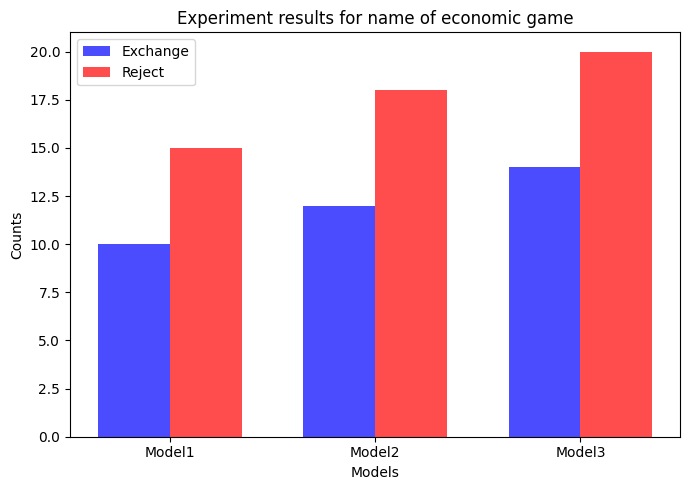

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_histogram(models, counts, experiment, response_labels):
    # Set the width of the bars
    width = 0.35
    ind = np.arange(len(models))  # the label locations

    fig, ax = plt.subplots(figsize=(7, 5))

    # Extract counts of a and b from the tuples
    a_counts = [c[0] for c in counts]
    b_counts = [c[1] for c in counts]

    # Create bar plots
    p1 = ax.bar(ind - width/2, a_counts, width, label=response_labels[0], color='blue', alpha=0.7)
    p2 = ax.bar(ind + width/2, b_counts, width, label=response_labels[1], color='red', alpha=0.7)

    # Add some text for labels, title, and legend
    ax.set_xlabel('Models')
    ax.set_ylabel('Counts')
    ax.set_title(f'Experiment results for {experiment}')
    ax.set_xticks(ind)
    ax.set_xticklabels(models)
    ax.legend()

    # Display the plot
    plt.tight_layout()
    plt.show()

# Sample data for testing
models = ['Model1', 'Model2', 'Model3']
counts = [(10, 15), (12, 18), (14, 20)]
plot_histogram(models, counts, "name of economic game", ("Exchange", "Reject"))

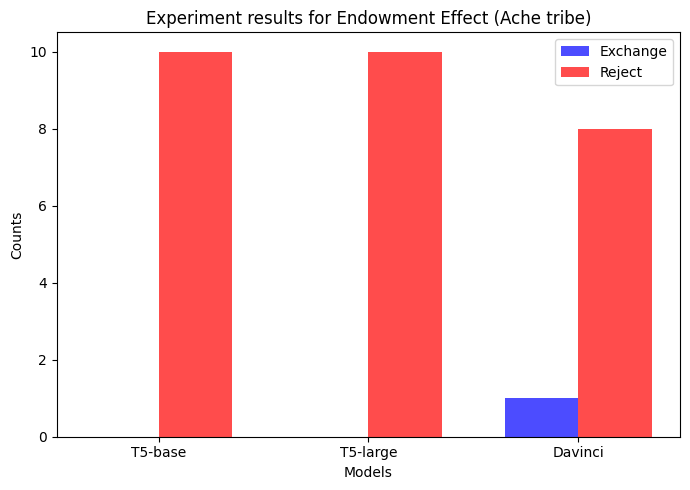

In [ ]:
models = ['T5-base', 'T5-large', 'Davinci']
counts = [(0, 10), (0, 10), (1, 8)]

plot_histogram(models,
               counts,
               "Endowment Effect (Ache tribe)",
               ("Exchange", "Reject"))

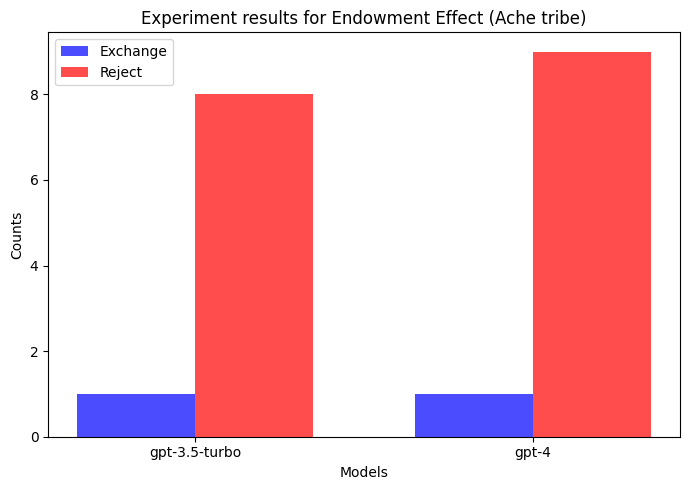

In [ ]:
chat_models = ['gpt-3.5-turbo', 'gpt-4']
chat_counts = [(1, 8), (1, 9)]

plot_histogram(chat_models,
               chat_counts,
               "Endowment Effect (Ache tribe)",
               ("Exchange", "Reject"))

## Completion vs Chat (?)

## Ultimatum Game

Add description of ultimatum game and brief literature review.


In [ ]:
system_prompt = f"You are a member of a tribe with the following characteristics: {tribe_prof}"

ultimatum_experiment = "You have been randomly chosen to be a recipient of an offer to split u$d 10 with someone else. If you reject the offer you and the other get nothing. How likely are you to accept $1? "
ultimatum_subject_task = "Reply on a scale from 0 to 10. A 0 means “not at all likely”, a 10 means “very likely”. You can use the values in between to indicate where you fall on the scale"

ultimatum_experiment_2 = "You are randomly chosen to be a recipient of an offer to split u$d 10 with someone else. You are offered u$d 2. If you reject the offer you and the other get nothing, if you accept then you get the offer and the other get the rest."
ultimatum_subject_task_2 = "Do you accept or reject the offer? Reply in one word with either 'accept' or 'reject'"

# completion prompt
completion_prompt = f"{system_prompt} \n\n Experiment description: {ultimatum_experiment_2} \n\n Task: {ultimatum_subject_task_2}"

# chat prompt (i.e., langchain messages)
messages = [
    SystemMessage(content=system_prompt),
    HumanMessage(content=completion_prompt)
]

In [ ]:
# util function to count accep/reject
import re

def count_ultimatum_responses(responses):
    accept_count = 0
    reject_count = 0

    for response in responses:
        string_lower = response.lower()  # Convert the string to lowercase to handle case variations
        if 'reject' in string_lower:
            reject_count += 1
        elif 'accept' in string_lower:
            accept_count += 1

    return accept_count, reject_count

# Example usage:
strings = ["I AccEpt", "I would accept the offer", "Reject", "I reJEct"]
accepts, rejects = count_ultimatum_responses(strings)
print(f"Accepts: {accepts}, Rejects: {rejects}")

Accepts: 2, Rejects: 2


## Open source completion vs Closed source completion (T5_base vs T5-large vs Davinci)


In [ ]:
# T5 base experiment
t5_base_results = {"Responses": [],
                "Response time": [],
                "Temperature": []}

for temp in temperatures:
    start_time = time.time()

    t5_base = HuggingFaceHub(repo_id="google/flan-t5-base",
                   model_kwargs={"temperature": temp,
                                 "max_length": 20})
    response = t5_base(completion_prompt)

    t5_base_results["Responses"].append(response)
    t5_base_results["Response time"].append(time.time() - start_time)
    t5_base_results["Temperature"].append(temp)

t5_base_results_df = pd.DataFrame(t5_base_results)
print(f"Results dataframe: \n{t5_base_results_df}\n\nCounts: {count_ultimatum_responses(t5_base_results_df['Responses'])}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:127: FutureWarning: '__init__' (from 'huggingface_hub.inference_api') is deprecated and will be removed from version '0.19.0'. `InferenceApi` client is deprecated in favor of the more feature-complete `InferenceClient`. Check out this guide to learn how to convert your script to use it: https://huggingface.co/docs/huggingface_hub/guides/inference#legacy-inferenceapi-client.
  warnings.warn(warning_message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:127: FutureWarning: '__init__' (from 'huggingface_hub.inference_api') is deprecated and will be removed from version '0.19.0'. `InferenceApi` client is deprecated in favor of the more feature-complete `InferenceClient`. Check out this guide to learn how to convert your script to use it: https://huggingface.co/docs/huggingface_hub/guides/inference#legacy-inferenceapi-client.
  warnings.warn(warning_message, FutureWar

Results dataframe: 
  Responses  Response time  Temperature
0    accept       1.228494          0.1
1    accept       0.781941          0.3
2    accept       0.645616          0.5
3    accept       0.796584          0.7
4    accept       0.607707          0.9
5    accept       0.710843          1.0
6    accept       0.766646          1.2
7    accept       0.795878          1.4
8    accept       0.715466          1.6
9    accept       0.720019          1.8

Counts: (10, 0)


In [ ]:
# T5 large experiment
t5_results = {"Responses": [],
            "Response time": [],
            "Temperature": []}

for temp in temperatures:
    start_time = time.time()

    t5_large = HuggingFaceHub(repo_id="google/flan-t5-large",
                   model_kwargs={"temperature": temp,
                                 "max_length": 20})
    response = t5_large(completion_prompt)

    t5_results["Responses"].append(response)
    t5_results["Response time"].append(time.time() - start_time)
    t5_results["Temperature"].append(temp)

t5_large_results_df = pd.DataFrame(t5_results)
print(f"Results dataframe: \n{t5_large_results_df}\n\nCounts: {count_ultimatum_responses(t5_large_results_df['Responses'])}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:127: FutureWarning: '__init__' (from 'huggingface_hub.inference_api') is deprecated and will be removed from version '0.19.0'. `InferenceApi` client is deprecated in favor of the more feature-complete `InferenceClient`. Check out this guide to learn how to convert your script to use it: https://huggingface.co/docs/huggingface_hub/guides/inference#legacy-inferenceapi-client.
  warnings.warn(warning_message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:127: FutureWarning: '__init__' (from 'huggingface_hub.inference_api') is deprecated and will be removed from version '0.19.0'. `InferenceApi` client is deprecated in favor of the more feature-complete `InferenceClient`. Check out this guide to learn how to convert your script to use it: https://huggingface.co/docs/huggingface_hub/guides/inference#legacy-inferenceapi-client.
  warnings.warn(warning_message, FutureWar

Results dataframe: 
  Responses  Response time  Temperature
0    accept       1.062810          0.1
1    accept       1.078268          0.3
2    accept       1.051273          0.5
3    accept       1.113302          0.7
4    accept       1.398433          0.9
5    accept       1.488980          1.0
6    accept       1.088119          1.2
7    accept       1.460714          1.4
8    accept       1.388656          1.6
9    accept       1.527358          1.8

Counts: (10, 0)


In [ ]:
# Davinci experiment
davinci_results = {"Responses": [],
                "Response time": [],
                "Temperature": []}

for temp in temperatures:
    start_time = time.time()

    davinci = OpenAI(model="text-davinci-003",
                     temperature=temp, max_tokens=20)

    response = davinci(completion_prompt)

    davinci_results["Responses"].append(response)
    davinci_results["Response time"].append(time.time() - start_time)
    davinci_results["Temperature"].append(temp)

davinci_results_df = pd.DataFrame(davinci_results)
print(f"Results dataframe: \n{davinci_results_df}\n\nCounts: {count_ultimatum_responses(davinci_results_df['Responses'])}")

Results dataframe: 
                                           Responses  Response time  \
0                                         \n\nReject       0.301866   
1                                         \n\nReject       1.387950   
2                                         \n\nReject       1.486378   
3                                         \n\nReject       0.469389   
4                                         \n\nReject       2.443043   
5                                         \n\nReject       0.598650   
6                                    only.\n\nReject       1.958210   
7                                         \n\nReject       0.399520   
8   confirms with an explanation\n\nGiven the com...       1.061767   
9                      \n\nI would reject the offer.       0.426005   

   Temperature  
0          0.1  
1          0.3  
2          0.5  
3          0.7  
4          0.9  
5          1.0  
6          1.2  
7          1.4  
8          1.6  
9          1.8  

Counts: (0

In [ ]:
davinci_results_df

,Responses,Response time,Temperature
0,\n\nReject.,0.955119,0.1
1,\n\nReject.,0.727612,0.3
2,\n\nReject,0.577260,0.5
3,\n\nReject.,0.349996,0.7
4,\n\nReject,0.371975,0.9
5,\n\nReject,0.788865,1.0
6,\n\nReject,0.322050,1.2
7,\n\nReject.,0.283099,1.4
8,\n\nReject.,0.429413,1.6
9,"As part of the Ache tribe with care, respect, ...",0.908542,1.8


## Open Source chat vs Closed Source chat

In [ ]:
# ChatGPT Experiment
chatGPT_results = {"Responses": [],
                "Response time": [],
                "Temperature": []}

for temp in temperatures:
    start_time = time.time()

    chatgpt = ChatOpenAI(model="gpt-3.5-turbo",
                         temperature=temp, max_tokens=20)

    response = chatgpt(messages)

    chatGPT_results["Responses"].append(response.content)
    chatGPT_results["Response time"].append(time.time() - start_time)
    chatGPT_results["Temperature"].append(temp)

chatGPT_results_df = pd.DataFrame(chatGPT_results)
print(f"Results dataframe: \n{chatGPT_results_df}\n\nCounts: {count_ultimatum_responses(chatGPT_results_df['Responses'])}")


Results dataframe: 
  Responses  Response time  Temperature
0    accept       1.061477          0.1
1    accept       0.425853          0.3
2    reject       3.125381          0.5
3    accept       0.822839          0.7
4    reject       0.495178          0.9
5    Accept       1.080192          1.0
6    accept       1.494306          1.2
7    reject       1.563137          1.4
8    accept       1.391826          1.6
9    accept       0.734273          1.8

Counts: (7, 3)


In [ ]:
chatGPT_results_df

,Responses,Response time,Temperature
0,accept,0.485893,0.1
1,accept,1.218456,0.3
2,reject,0.587575,0.5
3,Accept,0.470253,0.7
4,reject,0.860044,0.9
5,Accept,0.900989,1.0
6,accept,0.872262,1.2
7,reject,0.571923,1.4
8,accept,0.229423,1.6
9,Do I have any prior knowledge or relationship ...,1.490731,1.8


In [ ]:
# GPT-4 experiment
GPT4_results = {"Responses": [],
                "Response time": [],
                "Temperature": []}

for temp in temperatures:
    start_time = time.time()

    gpt4 = ChatOpenAI(model="gpt-4",
                         temperature=temp, max_tokens=35)

    response = gpt4(messages)

    GPT4_results["Responses"].append(response.content)
    GPT4_results["Response time"].append(time.time() - start_time)
    GPT4_results["Temperature"].append(temp)

GPT4_results_df = pd.DataFrame(GPT4_results)
print(f"Results dataframe: \n{GPT4_results_df}\n\nCounts: {count_ultimatum_responses(GPT4_results_df['Responses'])}")

Results dataframe: 
  Responses  Response time  Temperature
0    accept       1.326642          0.1
1    accept       1.686733          0.3
2    accept       0.505480          0.5
3    accept       0.959748          0.7
4    accept       1.520154          0.9
5    accept       1.188988          1.0
6    accept       1.976554          1.2
7    accept       0.334458          1.4
8    accept       1.395791          1.6
9    accept       0.338156          1.8

Counts: (10, 0)


In [ ]:
# Some chat model from huggingface
GPT4_results_df

,Responses,Response time,Temperature
0,"As a member of the Hadza tribe, I would rate m...",2.056559,0.1
1,8,0.406481,0.3
2,Given the Hadza tribe's values of equality and...,2.572002,0.5
3,Given the Hadza tribe's values of equality and...,2.568928,0.7
4,"10. As a member of the Hadza tribe, I have bee...",2.047244,0.9
5,8,0.696669,1.0
6,"As a Hadza tribesperson, I value equality and ...",2.623924,1.2
7,Considering the Hadza's value of sharing resou...,2.104148,1.4
8,Given the values and practices of the Hadza tr...,3.348929,1.6
9,Regaki Other you pointshapespake[sub]()\nPart ...,2.518907,1.8


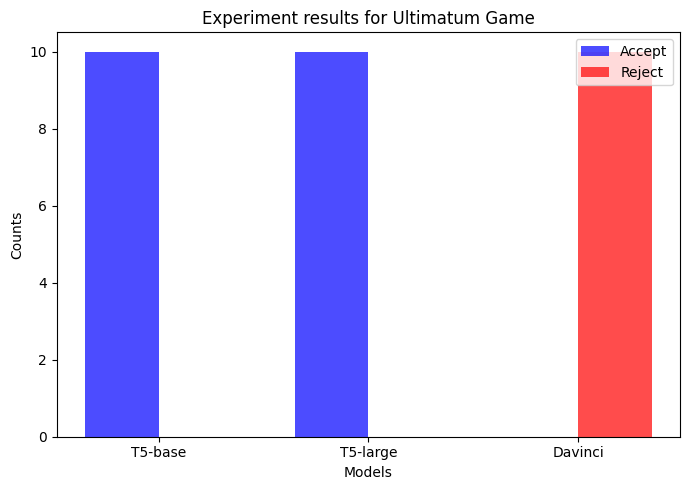

In [ ]:
models = ['T5-base', 'T5-large', 'Davinci']
counts = [(10, 0), (10, 0), (0, 10)]

plot_histogram(models,
               counts,
               "Ultimatum Game",
               ("Accept", "Reject"))

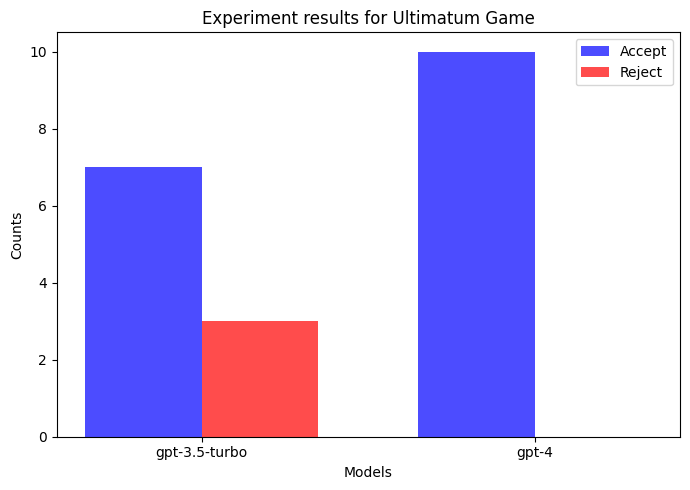

In [ ]:
chat_models = ['gpt-3.5-turbo', 'gpt-4']
chat_counts = [(7, 3), (10, 0)]

plot_histogram(chat_models,
               chat_counts,
               "Ultimatum Game",
               ("Accept", "Reject"))